### Переходим к практике

In [40]:
import pandas as pd

Наши новости

In [41]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [42]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [43]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [44]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [45]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [46]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [47]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [48]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 30.5 s


In [49]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 52s


А теперь в 3 строчки обучим нашу модель

In [50]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [51]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [17]:
common_dictionary[10]

'ватутин'

Запускаем обучение

In [62]:
from gensim.models import LdaModel

In [63]:
LdaModel?

In [64]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 34.9 s


In [28]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [75]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 


['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(11, 0.1109795), (14, 0.098929934), (20, 0.7204787), (23, 0.05068421)]

In [66]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год который это также компания человек страна
topic_1: операция канал врач лечение умереть фронт производить
topic_2: пенсия внутренний год анализ обнаружить свой спасти
topic_3: кремль ск применение статья отреагировать арабский индонезия
topic_4: земля год это сша американский который ребёнок
topic_5: градус билет разместить автобус бежать рот распределение
topic_6: газ исследование пациент помощь агентство остров восточный
topic_7: пресссекретарить налог белоруссия песок опасаться путин белорусский
topic_8: взрыв смерть препарат квартира болезнь пострадать трагедия
topic_9: банк журнал год миссия связанный который тело
topic_10: ребёнок жизнь возраст человек конкурс звезда век
topic_11: год это дело который суд свой мочь
topic_12: британский восток великобритания смерть год иск океан
topic_13: это который мочь всё свой день время
topic_14: это год который мочь весь россия nn
topic_15: китай станция год млн китайский энергия японский
topic_16: суд обращение знаменитый напомн

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [76]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [77]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.19783,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.246867,0.0,0.341890,0.010140,0.000000,0.0,0.0,0.000000
1,4896,0.000000,0.00000,0.059620,0.0,0.0,0.000000,0.0,0.0,0.708694,...,0.0,0.0,0.209677,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,4897,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.725508,0.000000,0.0,0.0,0.025875
3,4898,0.351604,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.153940,0.0,0.000000,0.215152,0.000000,0.0,0.0,0.000000
4,4899,0.000000,0.00000,0.053983,0.0,0.0,0.255053,0.0,0.0,0.000000,...,0.0,0.0,0.090385,0.0,0.489834,0.000000,0.088423,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [33]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [78]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [79]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.35488167,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09412611, 0.05493458, 0.        , 0.12692849, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12306967,
       0.08985786, 0.14527436, 0.        , 0.        , 0.        ])

In [143]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #user_vector = np.mean(user_vector, 0)
    #user_vector = np.median(user_vector, 0)
    user_vector = np.amax(user_vector, 0)
    return user_vector

In [144]:
get_user_embedding(user_articles_list)

array([0.54998094, 0.08535435, 0.05898862, 0.03954484, 0.154054  ,
       0.        , 0.03539763, 0.0957874 , 0.        , 0.        ,
       0.02818172, 0.40953958, 0.        , 0.08957732, 0.45688543,
       0.0437775 , 0.04436915, 0.02599109, 0.        , 0.63179594,
       0.024142  , 0.25777656, 0.0969868 , 0.0131314 , 0.01348801])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [145]:
#users['articles'].iloc[33]

In [146]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [147]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.709749,0.062237,0.029258,0.011437,0.354882,0.000000,0.029860,0.048540,0.091213,...,0.172465,0.000000,0.000000,0.0,0.123070,0.089858,0.726885,0.000000,0.000000,0.0
1,u108690,0.243338,0.012922,0.055294,0.013928,0.189287,0.000000,0.050680,0.013776,0.025541,...,0.063064,0.056967,0.025861,0.0,0.339300,0.000000,0.415150,0.057959,0.000000,0.0
2,u108339,0.306301,0.213383,0.062952,0.023222,0.026545,0.018343,0.042383,0.000000,0.160438,...,0.023056,0.019545,0.000000,0.0,0.432674,0.016589,0.324418,0.026569,0.068058,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [148]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [149]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.709749,0.062237,0.029258,0.011437,0.354882,0.000000,0.029860,0.048540,0.091213,...,0.000000,0.000000,0.0,0.123070,0.089858,0.726885,0.000000,0.000000,0.0,0
1,u108690,0.243338,0.012922,0.055294,0.013928,0.189287,0.000000,0.050680,0.013776,0.025541,...,0.056967,0.025861,0.0,0.339300,0.000000,0.415150,0.057959,0.000000,0.0,1
2,u108339,0.306301,0.213383,0.062952,0.023222,0.026545,0.018343,0.042383,0.000000,0.160438,...,0.019545,0.000000,0.0,0.432674,0.016589,0.324418,0.026569,0.068058,0.0,1


In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [151]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [152]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.21309617e-02, 2.05510113e-05, 7.76558198e-01, 2.43584086e-01,
       2.31826577e-02, 7.96057546e-03, 1.24770323e-01, 1.42355377e-03,
       3.86108969e-02, 2.38697608e-01])

In [154]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [155]:
import itertools

In [128]:
#Metrics_list =[]

In [156]:

#Metrics_dict = {}
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
#Metrics_dict['Name']='Max'
#Metrics_dict['f1']=fscore[ix]
#Metrics_dict['precision']=precision[ix]
#Metrics_dict['recall']=recall[ix]
#Metrics_list.append(Metrics_dict)

Best Threshold=0.340949, F-Score=0.797, Precision=0.786, Recall=0.808
[{'Name': 'Mean', 'f1': 0.7702407002188184, 'precision': 0.8301886792452831, 'recall': 0.7183673469387755}, {'Name': 'Median', 'f1': 0.7938931297709925, 'precision': 0.7455197132616488, 'recall': 0.8489795918367347}, {'Name': 'Max', 'f1': 0.7967806841046278, 'precision': 0.7857142857142857, 'recall': 0.8081632653061225}]


In [158]:
from pprint import pprint
pprint(Metrics_list)

[{'Name': 'Mean',
  'f1': 0.7702407002188184,
  'precision': 0.8301886792452831,
  'recall': 0.7183673469387755},
 {'Name': 'Median',
  'f1': 0.7938931297709925,
  'precision': 0.7455197132616488,
  'recall': 0.8489795918367347},
 {'Name': 'Max',
  'f1': 0.7967806841046278,
  'precision': 0.7857142857142857,
  'recall': 0.8081632653061225}]


In [160]:
df1 = pd.DataFrame(Metrics_list)
df1

,Name,f1,precision,recall
0,Mean,0.770241,0.830189,0.718367
1,Median,0.793893,0.745520,0.848980
2,Max,0.796781,0.785714,0.808163


In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1719   36]
 [  70  175]]


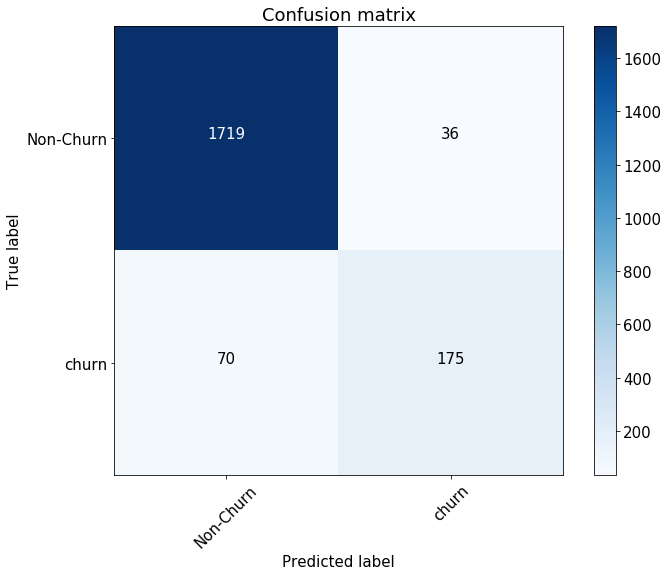

In [99]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [100]:
roc_auc_score(y_test, preds)

0.9698028955171812

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Дополнительно, библиотеки для анализа текста
1. spacy 
2. natasha
3. nltk